# Lesson 2: Dask DataFrames

In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from dask.distributed import Client
from IPython.display import Image

sns.set(style="white", context="talk")

%matplotlib inline

## Creating `dask` `DataFrames`

__From streams:__

* read_table/read_csv
* read_parquet
* read_json
* from_pandas
* read_sql_table


__From other Dask data structures:__

* from_delayed
* from_dask_array
* `Bag.to_dataframe`

If you're using Dask, it's likely your data does not fit in memory.

If your data fits in memory, maybe don't use Dask...

## NYC Taxi Trips & Fares

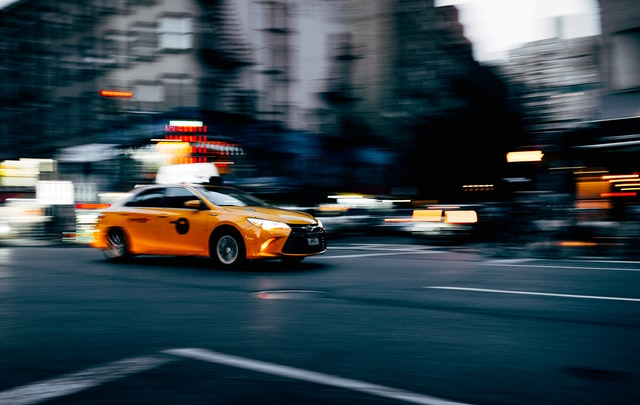

In [2]:
Image("images/taxi-small.jpg")

The full 2013 dataset is too __large__ _for an interactive workshop_, so I've created a subset of the data from only December, 2013.

http://www.andresmh.com/nyctaxitrips/

* [Trip Data](https://archive.org/download/nycTaxiTripData2013/trip_data.7z) - 4.1 GB
* [Fare Data](https://archive.org/download/nycTaxiTripData2013/trip_fare.7z) - 1.7 GB


## Lazily read the taxi data

In [3]:
client = Client()

In [51]:
trips = dd.read_parquet("data/taxi-small/trips.parq/")
fares = dd.read_parquet("data/taxi-small/fares.parq/")

Check the [read_parquet](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.read_parquet) parameters from time-to-time. Due to ongoing `pyarrow` improvements, parquet functionality is changing rapidly!

In [5]:
trips.npartitions

31

In [6]:
trips.head(compute=False)

,medallion_id,hack_license_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude
npartitions=1,,,,,,,,
2013-12-01,uint16,uint16,uint8,uint32,uint32,float64,float64,float64
2013-12-02,...,...,...,...,...,...,...,...


We now have 32 tasks (31 partitions + 1 `head` task) that have not yet been evaluated.

## Selecting data

Use standard `pandas` boolean queries.

In [7]:
trips[trips.passenger_count > 4].shape[0].compute()

33249

This will be parallelized and is quite performant.

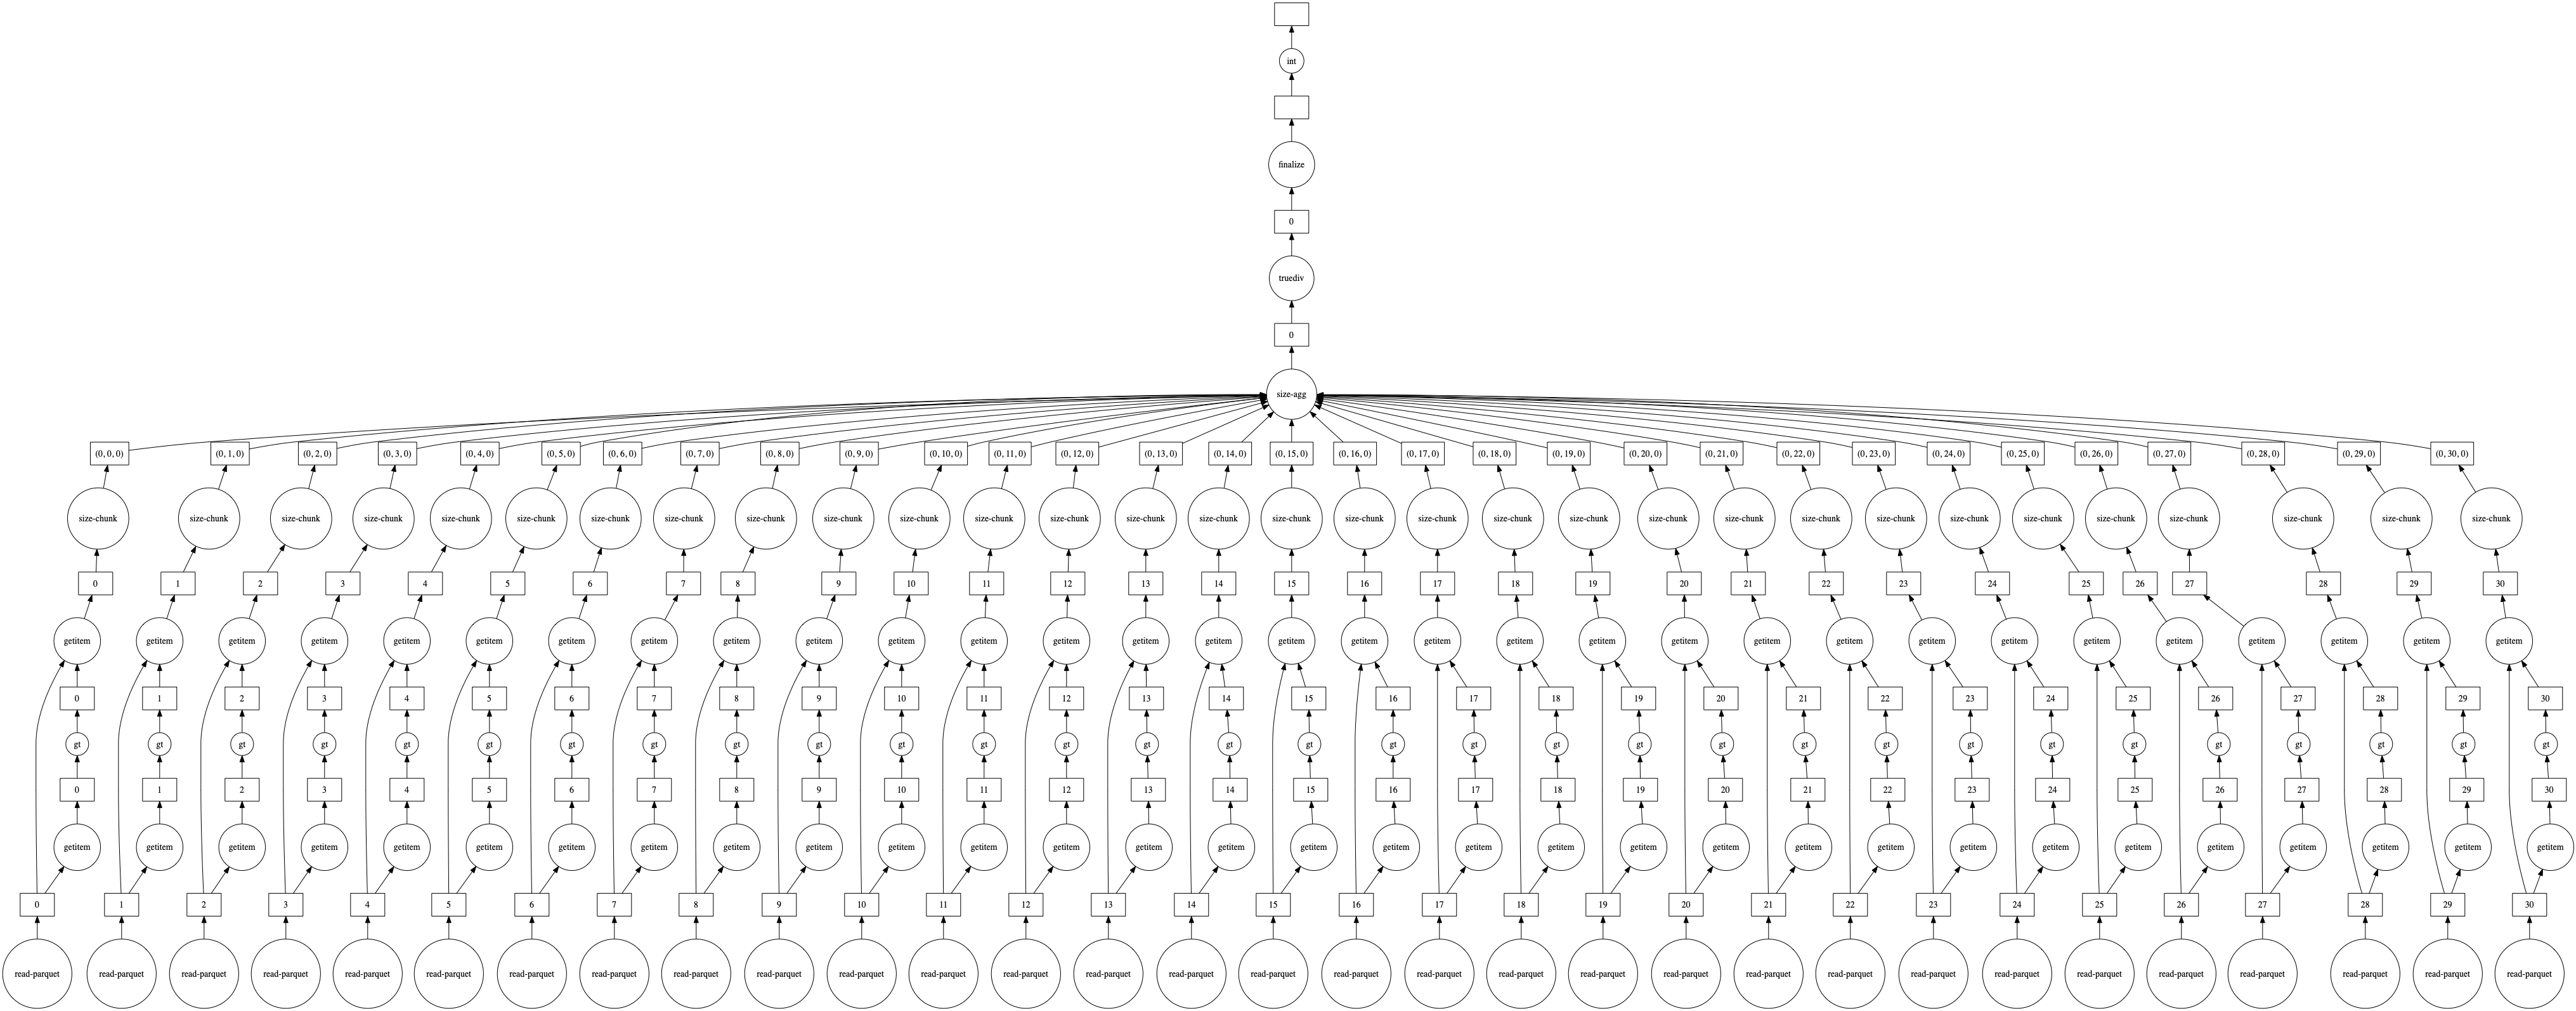

In [8]:
trips[trips.passenger_count > 4].shape[0].visualize()

### Selection on the index is fast

In [9]:
xmas = trips.loc["2013-12-25", :]

In [10]:
%time xmas_df = xmas.compute()

CPU times: user 10.5 ms, sys: 3.48 ms, total: 14 ms
Wall time: 26.8 ms


In [11]:
xmas['trip_distance'].mean().compute()

3.154237343317597

Use fancy `pandas` datetime indexing.

In [12]:
first_half = trips.loc["2013-12-01":"2013-12-15", :]
first_half["trip_distance"].mean().compute()

2.9317822294093703

### `iloc` doesn't work

Dask does not keep track of partition length [(link)](https://docs.dask.org/en/latest/dataframe-indexing.html#positional-indexing).

In [13]:
try:
    trips.iloc[:5, :]
except NotImplementedError as e:
    print(e)

'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.


## Working with the `Index`

`trips` was serialized to parquet format with `pickup_datetime` as the index. This index is restored when we load `trips`.

A `dask.DataFrame` sorted along the `index` will have `df.known_divisions` evaluate to `True`.

In [14]:
trips.known_divisions

True

`divisions` shows us the range of values in each partition.

In [15]:
trips.divisions

(Timestamp('2013-12-01 00:00:00'),
 Timestamp('2013-12-02 00:00:00'),
 Timestamp('2013-12-03 00:00:00'),
 Timestamp('2013-12-04 00:00:17'),
 Timestamp('2013-12-05 00:00:04'),
 Timestamp('2013-12-06 00:00:00'),
 Timestamp('2013-12-07 00:00:00'),
 Timestamp('2013-12-08 00:00:00'),
 Timestamp('2013-12-09 00:00:00'),
 Timestamp('2013-12-10 00:00:00'),
 Timestamp('2013-12-11 00:00:00'),
 Timestamp('2013-12-12 00:00:00'),
 Timestamp('2013-12-13 00:00:00'),
 Timestamp('2013-12-14 00:00:00'),
 Timestamp('2013-12-15 00:00:00'),
 Timestamp('2013-12-16 00:00:00'),
 Timestamp('2013-12-17 00:00:00'),
 Timestamp('2013-12-18 00:00:00'),
 Timestamp('2013-12-19 00:00:00'),
 Timestamp('2013-12-20 00:00:00'),
 Timestamp('2013-12-21 00:00:00'),
 Timestamp('2013-12-22 00:00:00'),
 Timestamp('2013-12-23 00:00:00'),
 Timestamp('2013-12-24 00:00:00'),
 Timestamp('2013-12-25 00:00:00'),
 Timestamp('2013-12-26 00:00:00'),
 Timestamp('2013-12-27 00:00:00'),
 Timestamp('2013-12-28 00:00:00'),
 Timestamp('2013-12-

## Pay attention to the index

The index is of greater importance in `Dask` than in `Pandas` because it determines the location of data.

Setting the index on a DataFrame is slow because data may need to be moved between processes/workers. This is called a shuffle - we'll discuss the [shuffle](https://docs.dask.org/en/latest/dataframe-groupby.html#difficult-cases) later.

Ideally, persist the index when you write data out to a format like Parquet avoid unnecessary shuffles.

Let's try changing up the index now. Recall we started with `pickup_datetime`.

In [40]:
trips_hk = trips.reset_index()\
    .set_index("hack_license_id").persist()

In [17]:
trips_hk.head()

,pickup_datetime,medallion_id,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude
hack_license_id,,,,,,,,
1,2013-12-19 20:34:00,1,1,1,1200,6.55,-73.965477,40.806160
1,2013-12-11 20:56:00,1,1,1,2040,4.03,-73.979393,40.763634
1,2013-12-07 21:08:00,1,1,1,780,4.10,-73.979988,40.726803
1,2013-12-12 22:18:00,1,1,1,240,0.45,-73.978386,40.761879
1,2013-12-18 18:53:00,1,1,1,960,2.43,-74.002274,40.740200


In [18]:
trips_hk.npartitions

31

In [19]:
trips_hk.divisions

(1,
 1223,
 1445,
 3031,
 3854,
 3939,
 5157,
 6814,
 7116,
 7600,
 8571,
 10631,
 11429,
 11945,
 12836,
 13698,
 16338,
 17816,
 18278,
 18394,
 19321,
 20967,
 22377,
 23097,
 23433,
 24546,
 26146,
 26807,
 27802,
 29751,
 30878,
 33369)

In [26]:
trips_dt = (trips.reset_index()
    .assign(date=lambda df: df.pickup_datetime.dt.normalize())
    .set_index("date")
    .persist()
)

## Groupby/Apply

Works mostly like Pandas.

Depending on how you're grouping, dask can take a slow or fast path.

Dask can efficiently perform split-apply-combinations the following conditions:

* group-on-index -> aggregate or apply
  * group-on-index + other columns -> aggregate or apply
* group -> aggregate

### Fastest GroupBy uses the index

Grouping along the index (or a computation on the index), is fast.

In [38]:
%time trips_1d = trips_dt.groupby("date").size().compute()

CPU times: user 40.9 ms, sys: 3.93 ms, total: 44.8 ms
Wall time: 76.5 ms


Can also add secondary grouping levels in addition to the index. There's more work here so will take more time than the last calculation.

In [39]:
%%time 
trips_dt.groupby(["date", "rate_code"])["trip_time_in_secs"]\
    .mean().compute()

CPU times: user 102 ms, sys: 9.49 ms, total: 111 ms
Wall time: 245 ms


date        rate_code
2013-12-01  0             631.600000
            1             673.815434
            2            2192.694779
            3            1961.033333
            4            1030.666667
                            ...     
2013-12-31  2            1849.281879
            3            1378.875000
            4            1288.500000
            5             317.681818
            6               6.000000
Name: trip_time_in_secs, Length: 174, dtype: float64

Datetime resampling also highly optimized

In [33]:
%time trips_5d = trips_dt.resample('1W').size().compute()

CPU times: user 80.9 ms, sys: 8.51 ms, total: 89.4 ms
Wall time: 174 ms


### Still Fast: Aggregations against non-index columns 

Aggregations, even on non-index columns, are fast, though against the index is fastest.

In [28]:
%time hack_avg = trips.groupby('hack_license_id')['trip_distance'].mean().compute()

CPU times: user 142 ms, sys: 12.7 ms, total: 155 ms
Wall time: 295 ms


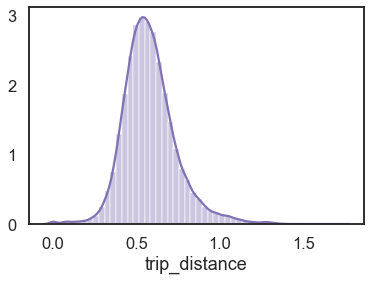

In [21]:
_ = sns.distplot(np.log10(1. + hack_avg), color="m")

### Apply is slow, unless against the index

In [47]:
%%time
dist_time_corr = (
    trips_hk.groupby("hack_license_id")
    .apply(lambda df: df.trip_time_in_secs.corr(df.trip_distance),
           meta=("corr", "f8"))
    .compute()
)

CPU times: user 329 ms, sys: 39.4 ms, total: 368 ms
Wall time: 3.74 s


### Slow aggregation

In [49]:
%%time
_ = (trips_dt.groupby("hack_license_id")
    .apply(lambda df: df.trip_time_in_secs.corr(df.trip_distance),
           meta=("corr", "f8"))
    .compute()
)

CPU times: user 1.24 s, sys: 87.6 ms, total: 1.33 s
Wall time: 5.6 s


### Unsupported Groupby Features

* Named Aggregations: `pd.NamedAgg`
* Grouper: `pd.Grouper`

In [ ]:
try:
    trips.groupby("passenger_count").agg(
        avg_distance=("trip_distance", "mean"),
        avg_time=("total_time", "mean")
    )
except TypeError as e:
    print(e)

## Merge/Join

Similar fast/slow cases to GroupBy.

* Fast: Share a common index (optional additional columns)
* Slow: No common index (requires a shuffle)

Also fast:

* Against a Pandas DataFrame
* Against a single-partition Dask DataFrame

In [59]:
# fast
%time taxi = dd.merge(trips, fares, on="pickup_datetime").persist()

CPU times: user 28.7 ms, sys: 2.68 ms, total: 31.4 ms
Wall time: 29.4 ms


In [60]:
# fast
common_cols = ["pickup_datetime", "medallion_id", "hack_license_id"]
%time taxi = dd.merge(trips, fares, on=common_cols).persist()

CPU times: user 31.4 ms, sys: 3.42 ms, total: 34.8 ms
Wall time: 32.6 ms


In [62]:
# nearly an order of magnitude slower
%time taxi = dd.merge(
    trips.reset_index(), fares.reset_index(), on=common_cols).persist()

CPU times: user 197 ms, sys: 10.1 ms, total: 207 ms
Wall time: 204 ms


## General computations

In [ ]:
df1.x + df2.y # fast

In [ ]:
df.rolling()

In [ ]:
df.where(df.x > 5, np.nan) # keep > 5 only, others nan
df.mask(df.5 < 5) # < 5 is nan

## Reshape/Pivot

* get_dummies
* pivot_table
* melt

## Dask Specific

df.map_partitions(

In [ ]:
repartition(divisions, npartitions, freq, partition_size) # one of these

In [ ]:
df.random_split([0.8, 0.2])

In [ ]:
df.rolling.map_overlap

# https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.rolling.map_overlap

### Series

In [ ]:
map_overlap

In [ ]:
nunique_approx

`split_every`: Group partitions into groups of this size while performing a tree-reduction. If set to False, no tree-reduction will be used. Default is 8.

## Save Dataframes

* to_csv
* to_parquet
* to_hdf
* to_json

### From Dask DataFrames
* to_delayed
* to_records
* to_bag
